# Malaria Deep Learning Model

# Import Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Loading Dataset

In [2]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
    split=['train'])

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Timothy Tandt\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection 

In [4]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [5]:
def splits(dataset: tf.data.Dataset, TRAIN_RATIO: float, VAL_RATIO: float, TEST_RATIO: float):
    DATASET_SIZE = len(dataset)
    
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(TEST_RATIO*DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [6]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Dataset Visualization

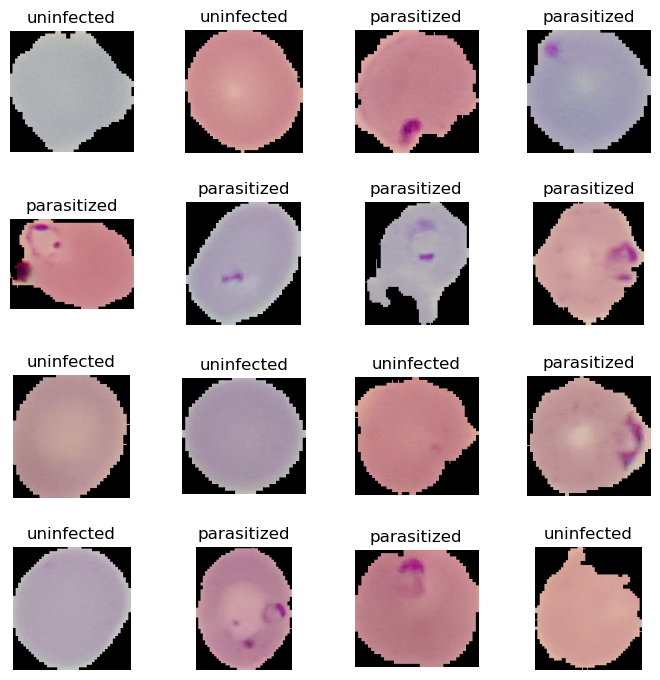

In [7]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# Iterate over the first 16 elements in the train_dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis("off")
    
# Show the plot
plt.show()

# Data Preprocessing

In [8]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [9]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [10]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
BATCH_SIZE = 32

In [12]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Model Creation

## Limit GPU Memory Usage

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [16]:
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [17]:
model = tf.keras.Sequential()

model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(100, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

In [19]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 0]

bce = BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1007609>

In [20]:
model.compile(optimizer=Adam(learning_rate=0.01), 
              loss=BinaryCrossentropy(),
              metrics="accuracy")

In [21]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 28s 31ms/step - loss: 0.3738 - accuracy: 0.8391 - val_loss: 0.7522 - val_accuracy: 0.8156
Epoch 2/20
689/689 [==============================] - 20s 29ms/step - loss: 0.2263 - accuracy: 0.9212 - val_loss: 1.5597 - val_accuracy: 0.5554
Epoch 3/20
689/689 [==============================] - 19s 28ms/step - loss: 0.2160 - accuracy: 0.9247 - val_loss: 0.1893 - val_accuracy: 0.9401
Epoch 4/20
689/689 [==============================] - 19s 28ms/step - loss: 0.1819 - accuracy: 0.9359 - val_loss: 0.2022 - val_accuracy: 0.9332
Epoch 5/20
689/689 [==============================] - 20s 29ms/step - loss: 0.1817 - accuracy: 0.9382 - val_loss: 0.3177 - val_accuracy: 0.9354
Epoch 6/20
689/689 [==============================] - 19s 28ms/step - loss: 0.1798 - accuracy: 0.9381 - val_loss: 0.2338 - val_accuracy: 0.9350
Epoch 7/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1513 - accuracy: 0.9502 - val_loss: 0.2817 - val_accuracy:

### 6. Plot out the performance

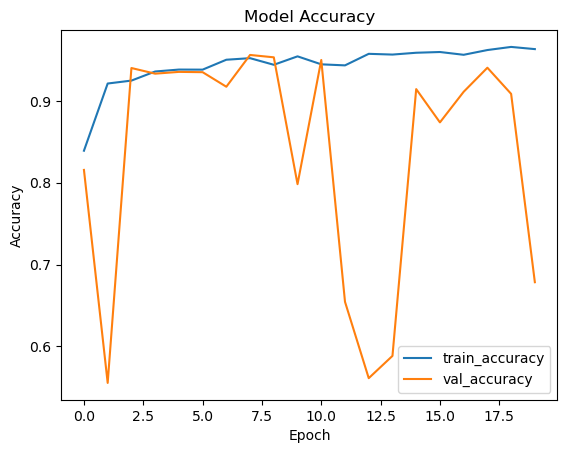

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [23]:
print(test_dataset, end='\n\n')
print(train_dataset)

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [24]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 10s 3ms/step - loss: 1.8856 - accuracy: 0.6899


[1.8855900764465332, 0.6898803114891052]

In [26]:
model_prediction = model.predict(test_dataset.take(1))
model_prediction

array([[0.00837578]], dtype=float32)

In [27]:
result = model_prediction[0][0]
result

0.0083757825

In [28]:
def parasite_or_not(x):
    if (x < 0.5):
        return 'Parasatize'
    return 'Uninfected'

In [29]:
parasite_or_not(result)

'Parasatize'

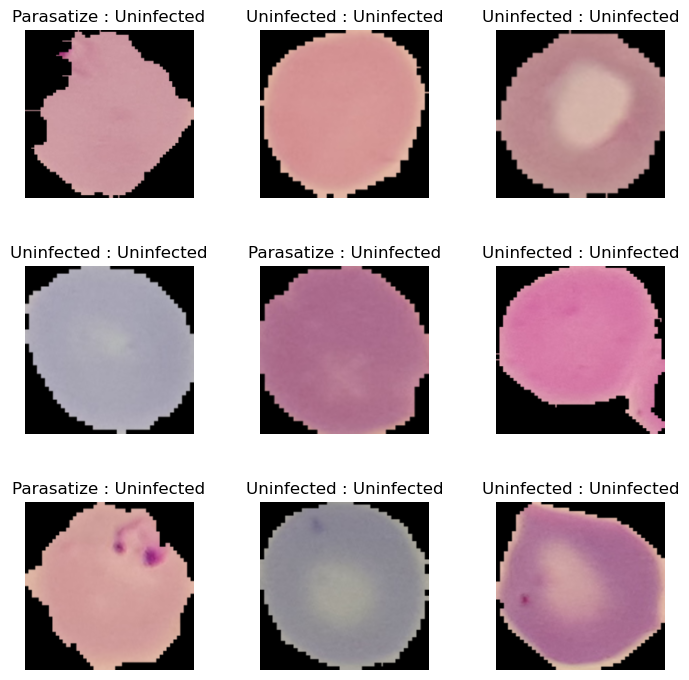

In [30]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

for i, (image, label) in enumerate(test_dataset.take(9)):
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    
    title = f"{parasite_or_not(label.numpy()[0])} : {parasite_or_not(model.predict(image)[0][0])}"
    plt.title(title)
    
    plt.axis("off")

# Loading and Saving

In [31]:
import os

In [32]:
current_directory = os.getcwd()
saved_path = os.path.join(current_directory, "model.h5")

In [33]:
model.save(saved_path)

In [34]:
loaded_model = tf.keras.models.load_model(saved_path)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Functional API

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [15]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [16]:
x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

In [17]:
lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     

In [18]:
lenet_model_func.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics="accuracy")

In [19]:
history = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 24s 27ms/step - loss: 0.4490 - accuracy: 0.7866 - val_loss: 1.1683 - val_accuracy: 0.5797
Epoch 2/5
689/689 [==============================] - 18s 26ms/step - loss: 0.2195 - accuracy: 0.9243 - val_loss: 0.1934 - val_accuracy: 0.9332
Epoch 3/5
689/689 [==============================] - 18s 26ms/step - loss: 0.1943 - accuracy: 0.9348 - val_loss: 0.2568 - val_accuracy: 0.9299
Epoch 4/5
689/689 [==============================] - 18s 26ms/step - loss: 0.1950 - accuracy: 0.9325 - val_loss: 0.2230 - val_accuracy: 0.9176
Epoch 5/5
689/689 [==============================] - 18s 25ms/step - loss: 0.1845 - accuracy: 0.9370 - val_loss: 0.1667 - val_accuracy: 0.9416


# Feature Extractor

In [20]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [21]:
x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)

x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

In [22]:
feature_extractor_model = Model(func_input, output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16

# Callable Model

In [23]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [24]:
x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

In [25]:
lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                

# Model Subclassing

In [34]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

In [32]:
class FeatureExtractor(Model):
    def __init__(self, filters: int, kernel_size: int, strides: int, padding: str, activation: str, pool_size: int):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)
        
        self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)
        
    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)

In [35]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)

        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation="relu")
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(10, activation="relu")
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation="sigmoid")
        
    def call(self, x, training):
        x = self.feature_extractor(x)
        
        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.batch_1(x)
        
        x = self.dense_2(x)
        x = self.batch_2(x)
        
        x = self.dense_3(x)
        
        return x

lenet_sub_classed = LenetModel()

In [33]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_4 (Featur  (None, 54, 54, 16)       1488      
 eExtractor)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_14 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                

In [38]:
lenet_sub_classed.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [39]:
lenet_sub_classed(tf.zeros([1, IM_SIZE, IM_SIZE, 3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_5 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_18 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_19 (Bat  multiple                 